In [113]:
import sys
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sklearn
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score as accuracy
from sklearn.preprocessing import StandardScaler
import pylab as pl
import ml_pipeline
%matplotlib inline

# Homework 2 – Machine Learning Pipeline

The purpose of this assigmnent is to build the first sketch of an in increasingly flexible, general machine learning pipeline, while testing it with a working example where we will try to predict which persons will experience financial distress in the next two years, using other information about them as features.

## 1. Load Data

In this case, the original dataset is in csv format (of course, that can change in future projects, so the associated function covers other possibilities).

In [116]:
df, df_dups = ml_pipeline.load_data('/Users/elenabg/Documents/ML/HW2/', 'credit-data.csv', dups=True)

## 2. Data Exploration

In [117]:
# 2.1
ml_pipeline.overview(df,df_dups)

DATASET  DIMENSIONS:41016 rows, 13 columns
DUPLICATE ROWS:0


PersonID                                  int64
SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
zipcode                                   int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

In [118]:
ml_pipeline.rename_cols(df, [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12], 
            ['per_id','ser_DLq2', 'rev_util', 'num_30_59_pastdue', 'debt_ratio','month_inc', 'open_cred_lines', 'num_90_pastdue', 'r_estate_loans', 
             'num_60_89_pastdue', 'num_dep'])

In [119]:
# 2.2
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
per_id,41016.0,115800.154598,28112.723511,22.0,106539.750000,119901.500000,134698.250000,149999.0
ser_DLq2,41016.0,0.161400,0.367904,0.0,0.000000,0.000000,0.000000,1.0
rev_util,41016.0,6.375870,221.618950,0.0,0.034310,0.189730,0.667160,22000.0
age,41016.0,51.683489,14.746880,21.0,41.000000,51.000000,62.000000,109.0
zipcode,41016.0,60623.824166,11.984357,60601.0,60618.000000,60625.000000,60629.000000,60644.0
num_30_59_pastdue,41016.0,0.589233,5.205628,0.0,0.000000,0.000000,0.000000,98.0
debt_ratio,41016.0,331.458137,1296.109695,0.0,0.176375,0.369736,0.866471,106885.0
month_inc,33042.0,6578.995733,13446.825930,0.0,3333.000000,5250.000000,8055.750000,1794060.0
open_cred_lines,41016.0,8.403477,5.207324,0.0,5.000000,8.000000,11.000000,56.0
num_90_pastdue,41016.0,0.419592,5.190382,0.0,0.000000,0.000000,0.000000,98.0


### 2.2: Variable Distributions

### 2.3 : Find outliers

In [120]:
vars_interest = ['rev_util', 'num_30_59_pastdue', 'debt_ratio','month_inc', 'open_cred_lines', 'num_90_pastdue', 'r_estate_loans', 
             'num_60_89_pastdue', 'num_dep']

outliers = ml_pipeline.find_outliers(df, vars_interest, 3.3)

In [121]:
for var, lst in outliers.items():
    print(str(var) +' : ' + str(len(lst)))

rev_util : 62
num_30_59_pastdue : 115
debt_ratio : 488
month_inc : 82
open_cred_lines : 323
num_90_pastdue : 115
r_estate_loans : 470
num_60_89_pastdue : 115
num_dep : 275


## 3. Pre-Processing

### 3.1: Count missing observations for each column

In [122]:
df.isnull().sum()

per_id                  0
ser_DLq2                0
rev_util                0
age                     0
zipcode                 0
num_30_59_pastdue       0
debt_ratio              0
month_inc            7974
open_cred_lines         0
num_90_pastdue          0
r_estate_loans          0
num_60_89_pastdue       0
num_dep              1037
dtype: int64

### 3.2:  Impute missing values

We could fill missing values for income and number of dependants using their respective sample means. However, averages are sensitive to outliers (of which we have a lot, as we saw before). Therefore, to be conservative we will use the __median__. Of course there are more sensible approaches, like using conditional mean or KNN to compute tailored estimates, but for the purposes of this exercise we will keep it simple.

In [123]:
df = ml_pipeline.impute(df, method = 'simple')
df[['month_inc', 'num_dep']].isnull().sum()

month_inc    0
num_dep      0
dtype: int64

### 3.3: Explore potential features

,ser_DLq2
ser_DLq2,1.000000
num_30_59_pastdue,0.149334
num_90_pastdue,0.139609
num_60_89_pastdue,0.121886
num_dep,0.066806
rev_util,-0.004586
r_estate_loans,-0.010641
debt_ratio,-0.013502
month_inc,-0.028426
open_cred_lines,-0.039898


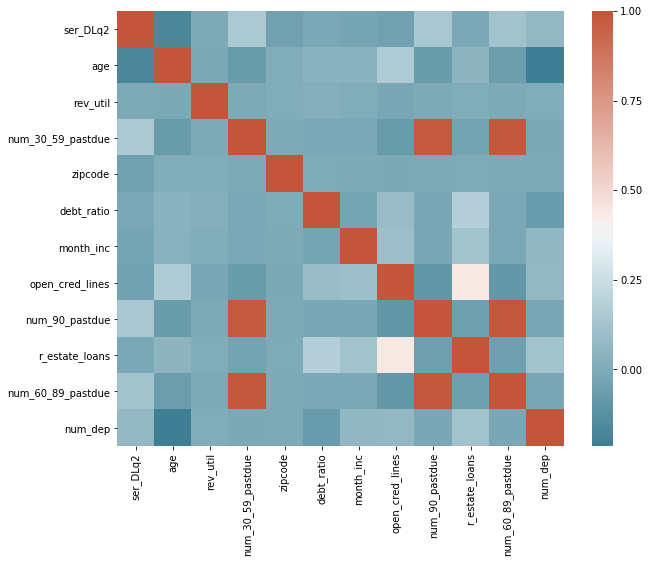

In [124]:
vars_interest = ['ser_DLq2', 'age', 'rev_util', 'num_30_59_pastdue', 'zipcode', 'debt_ratio','month_inc', 'open_cred_lines', 'num_90_pastdue', 'r_estate_loans', 
             'num_60_89_pastdue', 'num_dep']
ml_pipeline.top_corr(df, vars_interest, 'ser_DLq2').to_frame()    

## 4. Generate Features/Predictors

In [87]:
# 4.1

df_dums = ml_pipeline.categorize(df, ['age', 'open_cred_lines', 'month_inc', 'rev_util', 'debt_ratio',  'num_30_59_pastdue', 'num_dep',\
                'r_estate_loans', 'num_90_pastdue', 'num_60_89_pastdue'],\
           [15, 15, 15, 15, 15])

In [125]:
df_dums.head()

,ser_DLq2,age_dum,open_cred_lines_dum,month_inc_dum,rev_util_dum,debt_ratio_dum,num_30_59_pastdue_dum,num_dep_dum,r_estate_loans_dum,num_90_pastdue_dum,num_60_89_pastdue_dum
0,0,5,0,0,14,3,0,0,0,0,0
1,0,8,1,14,8,0,0,0,2,0,0
2,0,5,1,4,0,0,0,0,0,0,0
3,0,5,3,10,13,0,4,0,3,0,0
4,0,4,1,11,0,0,0,2,0,0,0


In [89]:
# 4.2 Visualize features


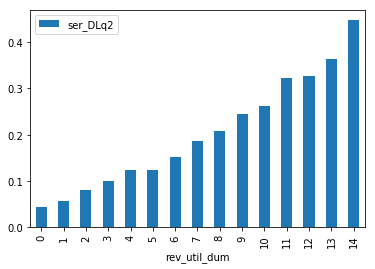

In [126]:
ml_pipeline.cond_mean(df_dums, 'rev_util_dum', 'ser_DLq2')

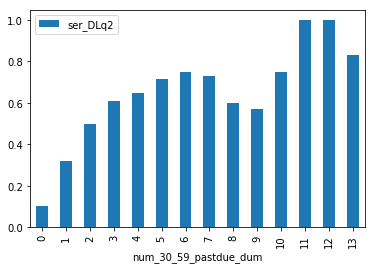

In [97]:
ml_pipeline.cond_mean(df_dums, 'num_30_59_pastdue_dum', 'ser_DLq2')

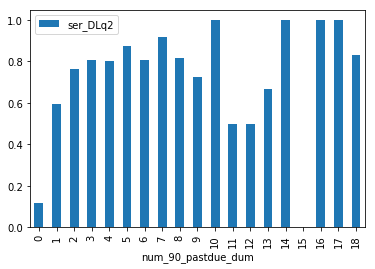

In [98]:
ml_pipeline.cond_mean(df_dums, 'num_90_pastdue_dum', 'ser_DLq2')

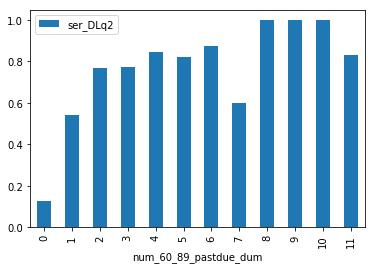

In [99]:
ml_pipeline.cond_mean(df_dums, 'num_60_89_pastdue_dum', 'ser_DLq2')  

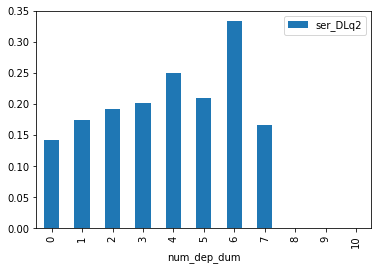

In [209]:
ml_pipeline.plot_cond_mean(df_dums, 'num_dep_dum', 'ser_DLq2')  

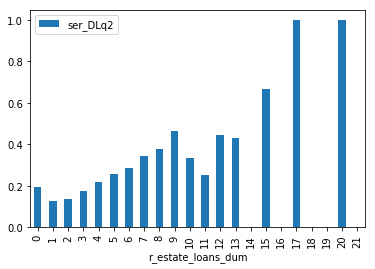

In [100]:
ml_pipeline.cond_mean(df_dums, 'r_estate_loans_dum', 'ser_DLq2')  

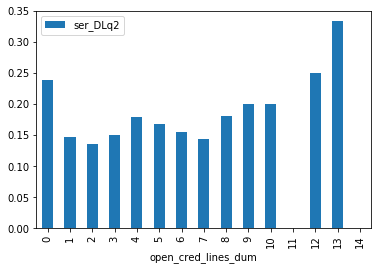

In [101]:
ml_pipeline.cond_mean(df_dums, 'open_cred_lines_dum', 'ser_DLq2')  

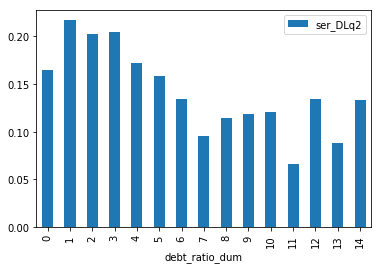

In [104]:
ml_pipeline.cond_mean(df_dums, 'debt_ratio_dum', 'ser_DLq2')  

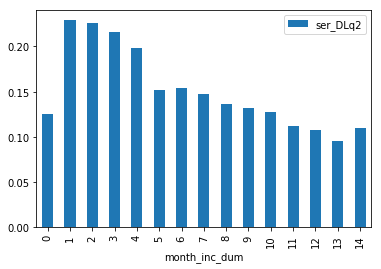

In [102]:
ml_pipeline.cond_mean(df_dums, 'month_inc_dum', 'ser_DLq2') 

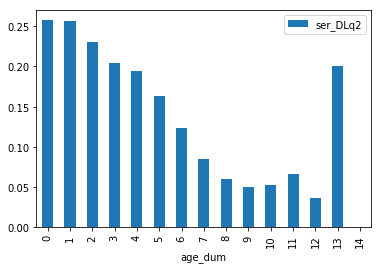

In [214]:
ml_pipeline.plot_cond_mean(df_dums, 'age_dum', 'ser_DLq2')  

Having inspected the features potentially useful for predicting delinquency, we can take a more formal approach using a __random forest__ algorithm that will reveal the __importance of each feature__.

First, let's __rescale__ income, so that standard deviations from the population mean are what matters. In this particular case, doing this is important because monthly income is measured in units of significantly larger magnitude than the rest of the features.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


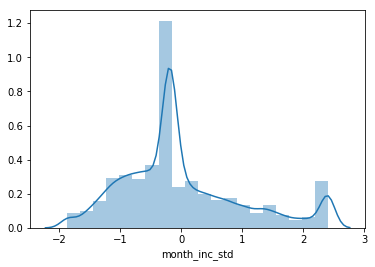

In [105]:
df['month_inc_std'] = ml_pipeline.standarize(df['month_inc'])
sns.distplot(df['month_inc_std'], bins = 20)

In [108]:
pot_features = np.array(['rev_util','age', 'zipcode',
       'num_30_59_pastdue', 'debt_ratio', 'month_inc_std', 'open_cred_lines',
       'num_90_pastdue', 'r_estate_loans', 'num_60_89_pastdue', 'num_dep'])

ml_pipeline.plot_importances(df, pot_features, 'ser_DLq2')

NameError: name 'RandomForestClassifier' is not defined

## 5. Build Classifier

In [32]:
features = ['ser_DLq2','rev_util','num_30_59_pastdue','num_90_pastdue','num_60_89_pastdue','num_dep',\
            'r_estate_loans','open_cred_lines','debt_ratio','month_inc_std','age']

x_train, x_test, y_train, y_test = ml_pipeline.split_dataset(df[features], 'ser_DLq2')
knn = ml_pipeline.fit_classifier('KNN', x_train, y_train)
dt = ml_pipeline.fit_classifier('DT', x_train, y_train)

## 6. Evaluate Classifier

In [33]:
acc_KNN = ml_pipeline.get_acc(knn, x_test, y_test)
acc_DT = ml_pipeline.get_acc(dt, x_test, y_test)

In [34]:
acc_KNN, acc_DT

(0.8607996099463676, 0.8720136518771331)